# Dataset Used = https://www.kaggle.com/datasets/devarajv88/target-dataset?select=products.csv

In [54]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='kashyap21',
    database='ecommerce_new'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'A:/Personal/Projects/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host='localhost',
                            user='root',
                            password='kashyap21',
                            database='ecommerce_new')

cur = db.cursor()

# Basic Questions 

# Q1. list all unique cities where customers are located. 

In [56]:
# Q1. list all unique cities where customers are located.

query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Q2. Count the number of order placed in 2017.

In [57]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Q3. Find the total sales per category.

In [58]:
query = """ select upper(products.product_category) as category,
            round(sum(payments.payment_value),2) as sales
            from products join order_items 
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category """
            
cur.execute(query)

data = cur.fetchall()

# Set pandas to display float numbers with 2 decimal places and avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format

df = pd.DataFrame(data,columns = ["Category","Sales"])
print(df)


                        Category      Sales
0                      PERFUMERY  506738.66
1           FURNITURE DECORATION 1430176.39
2                      TELEPHONY  486882.05
3   FASHION BAGS AND ACCESSORIES  218158.28
4                 BED TABLE BATH 1712553.67
..                           ...        ...
69                CDS MUSIC DVDS    1199.43
70                    LA CUISINE    2913.53
71   FASHION CHILDREN'S CLOTHING     785.67
72                      PC GAMER    2174.43
73        INSURANCE AND SERVICES     324.51

[74 rows x 2 columns]


# Q4. Calculate the percentage of orders that were paid in installments.

In [59]:
query = """ select (sum(case when payment_installments >= 1 then 1 
            else 0 end)) / count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

" The percentage of orders that were paid in instalments is", data[0][0]

(' The percentage of orders that were paid in instalments is',
 Decimal('99.9981'))

# Q5. Count the number of customers from each state.

   state  customer_count
0     SP           41746
4     RJ           12852
2     MG           11635
5     RS            5466
3     PR            5045
1     SC            3637
9     BA            3380
13    DF            2140
8     ES            2033
7     GO            2020
15    PE            1652
12    CE            1336
6     PA             975
16    MT             907
10    MA             747
11    MS             715
21    PB             536
23    PI             495
14    RN             485
19    AL             413
25    SE             350
22    TO             280
20    RO             253
17    AM             148
24    AC              81
18    AP              68
26    RR              46


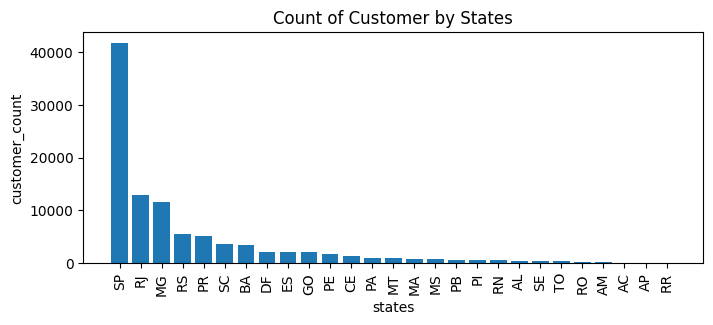

In [60]:
query = """ select customer_state , count(customer_id) 
            from customers
            group by customer_state """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
print(df)

plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customer by States")
plt.show()
# " The percentage of orders that were paid in instalments is", data[0][0]

# Intermediate Queries

# Q1. Calculate the number of orders per month in 2018.

      Months  Order_count
0      April         6939
1     August         6512
2   February         6728
3    January         7269
4       July         6292
5       June         6167
6      March         7211
7        May         6873
8    October            4
9  September           16


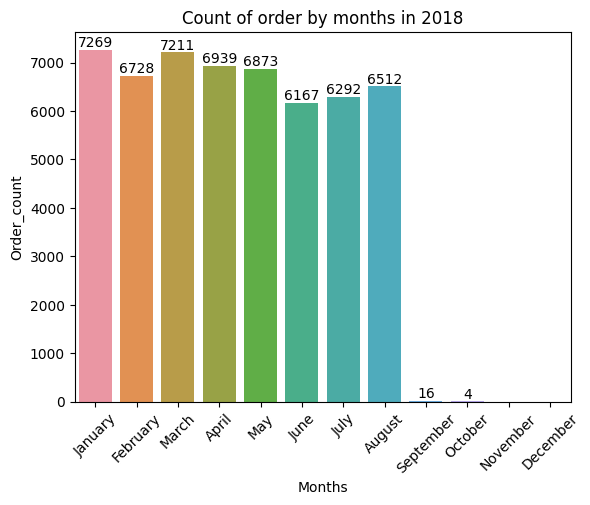

In [61]:
query = """ select monthname(order_purchase_timestamp) as months,
            count(order_id) as order_count from orders
            where year(order_purchase_timestamp) = "2018"
            group by monthname(order_purchase_timestamp)
            order by monthname(order_purchase_timestamp); """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Months','Order_count'])
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]

ax = sns.barplot(x = df["Months"], y = df["Order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of order by months in 2018")

print(df)

plt.show()

# Q2. Find the average number of products per order, grouped by customer city.

In [62]:
query = """ with count_per_order as
            (select orders.order_id, orders.customer_id, 
            count(order_items.order_id) as order_count
            from orders 
            join order_items
            on orders.order_id = order_items.order_id
            group by orders.order_id, orders.customer_id)
            
            select customers.customer_city, 
            round(avg(count_per_order.order_count),2) as average_orders
            from customers
            join count_per_order
            on customers.customer_id = count_per_order.customer_id
            group by customers.customer_city
            order by average_orders desc; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer city",'Average Products/Order'])
df.head(10)

,Customer city,Average Products/Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Q3. Calculate the percentage of total revenue contributed by each product category.

In [63]:
query = """ select upper(products.product_category) as category,
            round((sum(payments.payment_value)/(select sum(payment_value) 
            from payments))*100,2) as sales_percentage
            from products join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category order by sales_percentage desc"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns= ['category','percentage distribution'])
df.head()

,category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Q4. Identify the correlation between product price and the number of times a product has been purchased.

In [64]:
import numpy as np

query = """ select products.product_category,
            count(order_items.product_id),
            round(avg(order_items.price),2)
            from products join order_items
            on products.product_id = order_items.product_id
            group by products.product_category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns= ['category','order_count','price'])
df.head()
print(df)

arr1 = df['order_count']
arr2 = df['price']

a = np.corrcoef([arr1,arr2])
print('The correlation between the price and number of times a product has been purchased is',a[0][1])

                           category  order_count  price
0                     HEALTH BEAUTY         9670 130.16
1                     sport leisure         8641 114.34
2                        Cool Stuff         3796 167.36
3              computer accessories         7827 116.51
4                   Watches present         5991 201.14
..                              ...          ...    ...
69                          flowers           33  33.64
70  Kitchen portable and food coach           15 264.57
71                  House Comfort 2           30  25.34
72       CITTE AND UPHACK FURNITURE           38 114.95
73                   cds music dvds           14  52.14

[74 rows x 3 columns]
The correlation between the price and number of times a product has been purchased is -0.10631514167157562


# Q5. Calculate the total revenue generated by each seller, and rank them by revenue.

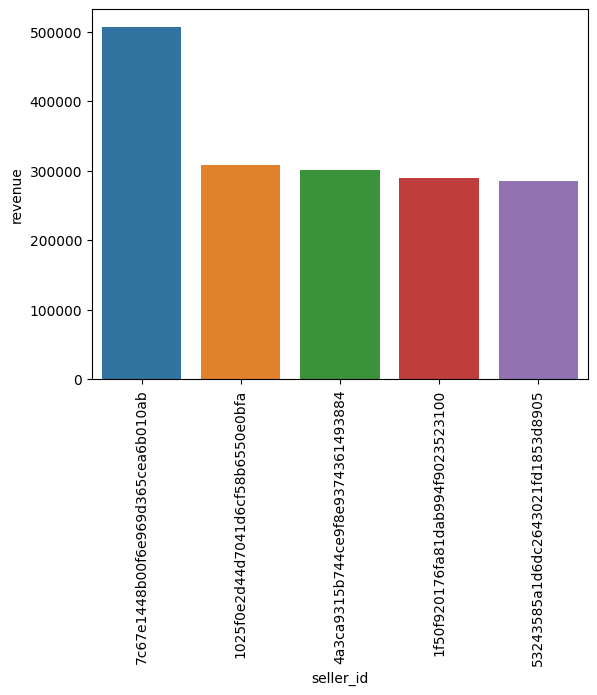

In [65]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
            (select order_items.seller_id, round(sum(payments.payment_value),2) as revenue 
            from order_items join payments
            on order_items.order_id = payments.order_id
            group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = 'seller_id', y = 'revenue' , data = df)
plt.xticks(rotation = 90)
plt.show()

# Advance

# Q1.Calculate the moving average of order values for each customer over their order history.

In [66]:
query = '''select customer_id, order_purchase_timestamp, payment,
            avg (payment) over (partition by customer_id 
            order by order_purchase_timestamp
            rows between 2 preceding and current row) as mov_avg
            from
            (select orders.customer_id, orders.order_purchase_timestamp,
            payments.payment_value as payment
            from payments join orders
            on payments.order_id = orders.order_id) as a'''
            
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_id","order_purchase_timestamp","payment","moving_average"])
df

,customer_id,order_purchase_timestamp,payment,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# Q2.Calculate the cumulative sales per month for each year.

In [67]:
query = """select years, months, payment,sum(payment)
            over (order by years, months) cumulative_sales 
            from
            (select year (orders.order_purchase_timestamp) as years,
            month (orders.order_purchase_timestamp) as months,
            round (sum(payments.payment_value), 2) as payment 
            from orders join payments
            on orders.order_id = payments.order_id
            group by years, months order by years, months) as a"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years","months","payment","cumulative_payment"])
df

,years,months,payment,cumulative_payment
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14
